# Opis środowiska eksperymentalnego

## Wykorzystane biblioteki i funkcje

In [1]:
import warnings

import numpy as np
from sklearn import svm
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier

import parse_stroke_data_file

warnings.filterwarnings("ignore")


## Ewaluacja klasyfikatorów

Ewaluacja każdego klasyfikatora była wykonywana
z wykorzystaniem pięciokrotnie powtarzanej metody
2-krotnej walidacji krzyżowej

In [2]:
N_SPLITS = 2
N_REPEATS = 5

Badania były przeprowadzane dla różnej
liczby cech. Poczynając od jednej - najlepszej, według rankingu cech wyznaczonego za pomocą `SelectKBest`,
kolejno dodawane były kolejne cechy. Nasz zbiór danych miał 59 cech.


In [8]:
FEATURES_RANGE = range(1,60, 5)

Do treningu wykorzystana została sieć jednokierunkowa z jedną warstwą ukrytą.
Sprawdziliśmy 3 różne liczby neuronów w warstwie ukrytej: 20, 50 oraz 90.
Przetestowane zostały klasyfikatory z parametrem `momentum` (pęd) o wartościach:

- 0: brak pędu
- 0.9: domyślny pęd w dla sztucznych sieci neuronowych w bibliotece `scikit-learn`

In [9]:
HIDDEN_LAYER_SIZES = [20, 50, 90]
MOMENTUM_VALUES = [0.0, 0.9]

# Implementacja środowiska eksperymentalnego

Kluczową część środowiska stanowi funkcja, generująca klasyfikatory. Każdy klasyfikator otrzymuje unikatową nazwę, opisującą jego konfigurację (liczbę cech, ilośc neuronów w ukrytych warstwach, wartość parametru `momentum`).

In [5]:
def get_classifiers():
    classifiers = {}
    for num_of_features in FEATURES_RANGE:
        for hidden_layer_size in HIDDEN_LAYER_SIZES:
            for momentum_value in MOMENTUM_VALUES:
                new_classifier = MLPClassifier(
                    hidden_layer_sizes=(hidden_layer_size,), momentum=momentum_value
                )

                new_classifier.num_of_features = num_of_features

                classifiers[(
                    num_of_features,
                    hidden_layer_size,
                    momentum_value
                )] = new_classifier

    return classifiers

Po wczytaniu zbioru uczącego, następuje ewaluacja każdego z klasyfikatorów. Proces ewaluacji składa się z:

- Załadowania odpowiedniego podzbioru zbioru uczącego (określonego przez liczbę cech, na jakich ma być trenowany klasyfikator)
- Pięciokrotna ewaluacja klasyfikatora na zbiorze danych, uczących i testowych, wygenerowanych za pomocą metody walidacji krzyżowej
- Zapisania sprawności klasyfikatora, policzonej za pomocą metody `accuracy_score`

Gdy wszystkie klasyfikatory zostały ocenione, ich sprawności zostają zapisane do pliku `results.npy`.

In [6]:
X, y = parse_stroke_data_file.get_dataset_x_y()
rskf = RepeatedStratifiedKFold(
    n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42
)  # haha śmieszna liczba 42 haha
classifiers = get_classifiers()

scores = np.zeros((len(classifiers), N_SPLITS * N_REPEATS))

for clf_id, clf_name in enumerate(classifiers):
    X_new = SelectKBest(
        chi2, k=classifiers[clf_name].num_of_features
    ).fit_transform(X, y)

    for fold_id, (train, test) in enumerate(rskf.split(X_new, y)):
        clf = clone(classifiers[clf_name])
        clf.fit(X_new[train], y[train])
        y_pred = clf.predict(X_new[test])
        scores[clf_id, fold_id] = accuracy_score(y[test], y_pred)

mean = np.mean(scores, axis=1)
std = np.std(scores, axis=1)

# for clf_id, clf_name in enumerate(classifiers):
#     print("%s: %.3f (%.2f)" % (clf_name, mean[clf_id], std[clf_id]))

np.save("results", scores)

# Analiza wyników

## Wstępne przetwarzanie wyników

Przed przystąpieniem do analizy, dane klasyfikatorów i osiągnięte sprawności zostały załadowane do tabeli `pandas`.
Pozwoli to wykonanie kolejnych wykresów.

In [6]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
from matplotlib.lines import Line2D
import pandas


clfs = get_classifiers()
scores = np.load("results.npy")

data_frame = None
first_element = True

results_python_dict = {
    'num_of_features': [ ],
    'hidden_layer_size': [ ],
    'momentum': [ ],
    'mean_score': [ ],
    'std_score': [ ]
}
for score, classifier in zip(scores, clfs):
    
    mean_score = np.mean(score)
    std_score = np.std(score)
    num_of_features, hidden_layer_size, momentum_value = classifier
    
    results_python_dict['num_of_features'].append(num_of_features)
    results_python_dict['hidden_layer_size'].append(hidden_layer_size)
    results_python_dict['momentum'].append(momentum_value)
    results_python_dict['mean_score'].append(mean_score)
    results_python_dict['std_score'].append(std_score)

results_pandas = pandas.DataFrame(results_python_dict)
del results_python_dict

print(results_pandas)

    num_of_features  hidden_layer_size  momentum  mean_score  std_score
0                 1                 20       0.0    0.301440   0.019691
1                 1                 20       0.9    0.309663   0.038802
2                 1                 50       0.0    0.312331   0.032511
3                 1                 50       0.9    0.291897   0.000786
4                 1                 90       0.0    0.306754   0.029062
..              ...                ...       ...         ...        ...
67               56                 20       0.9    0.624410   0.052469
68               56                 50       0.0    0.697675   0.016968
69               56                 50       0.9    0.698339   0.020551
70               56                 90       0.0    0.714762   0.015031
71               56                 90       0.9    0.722974   0.013932

[72 rows x 5 columns]


## Sprawność klasyfikatorów a rozmiar warstwy ukrytej

Pierwszym krokiem podjętym w celu przeanalizowania wyników było utworzenie wykresu ilustrującego uzyskaną 
przez klasyfikatory sprawność, w zależności od liczby neuronów w ukrytych warstwach.

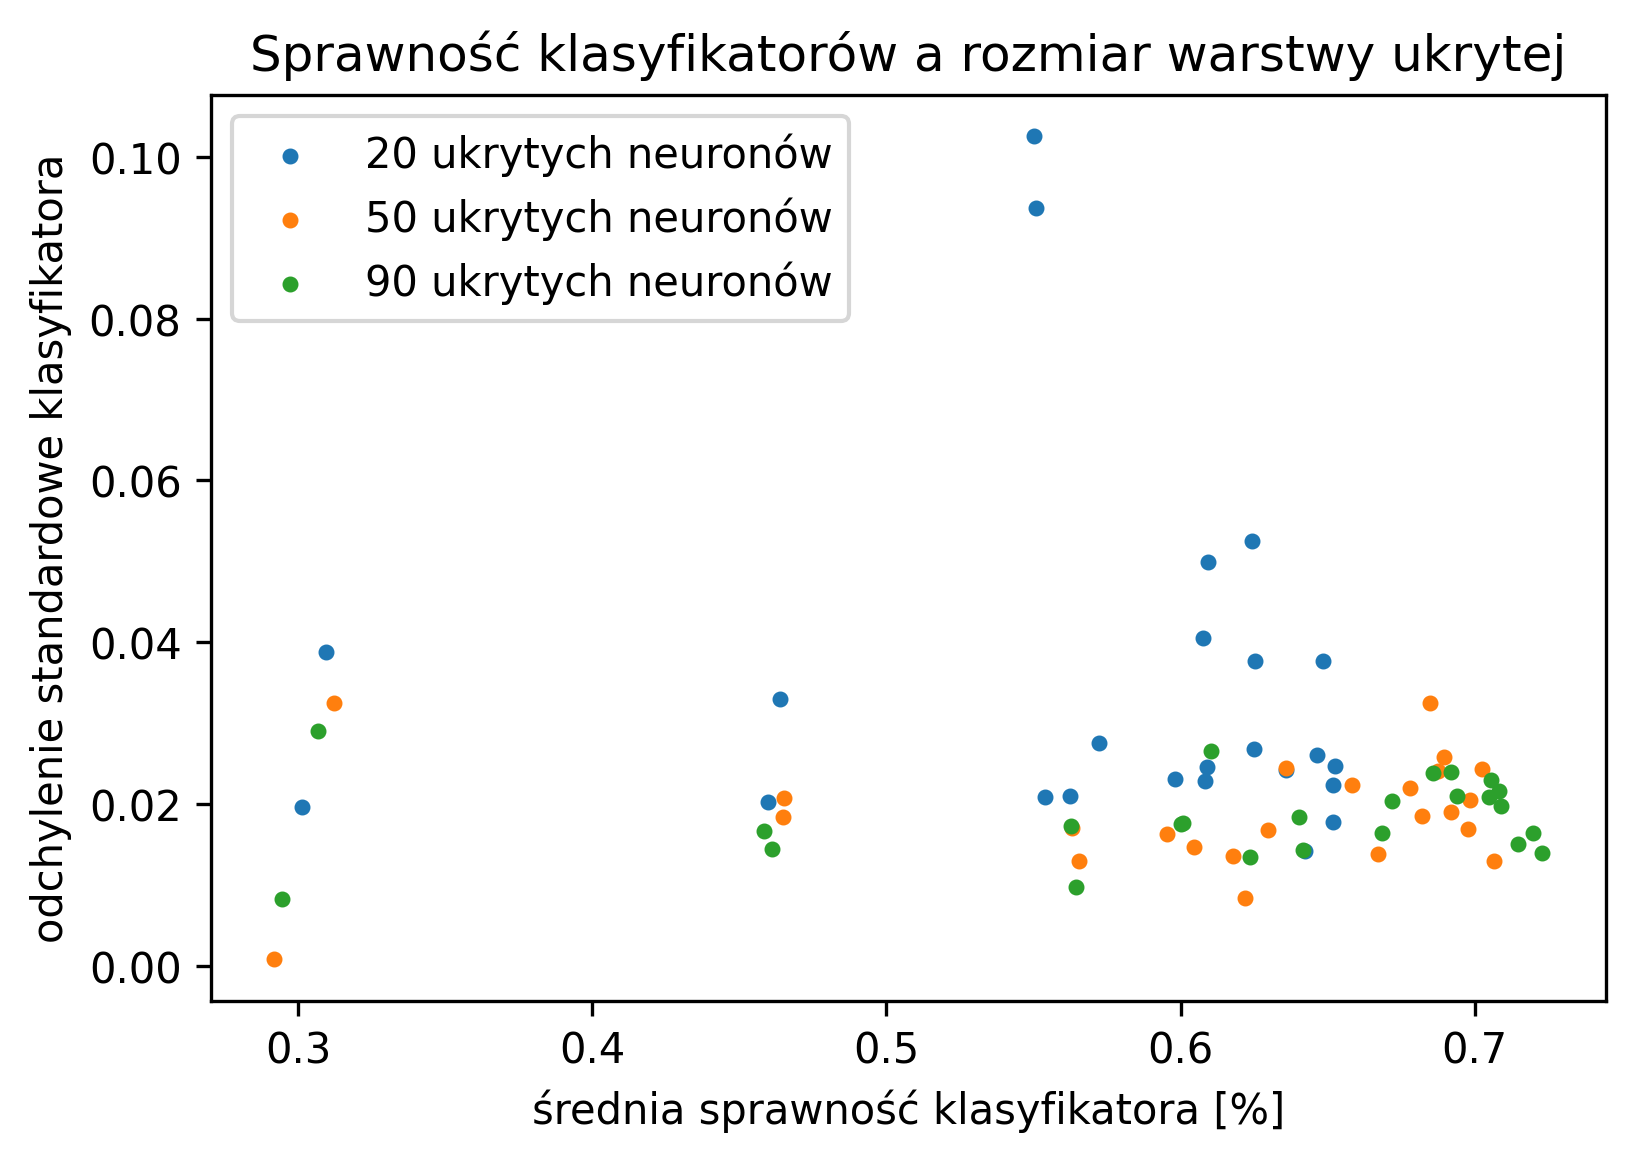

In [7]:
fig, ax = plt.subplots()

hidden_size_20 = results_pandas[results_pandas['hidden_layer_size'] == 20]
hidden_size_50 = results_pandas[results_pandas['hidden_layer_size'] == 50]
hidden_size_90 = results_pandas[results_pandas['hidden_layer_size'] == 90]

datas = [ hidden_size_20, hidden_size_50, hidden_size_90 ]
labels = [
    '20 ukrytych neuronów',
    '50 ukrytych neuronów',
    '90 ukrytych neuronów',
]

for data, label in zip(datas, labels):
    ax.scatter(
        data['mean_score'], data['std_score'], label=label, s=8
    )

plt.title('Sprawność klasyfikatorów a rozmiar warstwy ukrytej')
ax.set_xlabel('średnia sprawność klasyfikatora [%]')
ax.set_ylabel('odchylenie standardowe klasyfikatora')
ax.legend()
plt.show()

Na wykresie dostrzegalna jest przewaga klasyfikatorów o większej liczbie neuronów w warstwie ukrytej. 
Zarówno pod względem sprawności jak i odchylenia standardowego są one lepsze, niż klasyfikatory o mniejszej liczbie 
neuronów.

## Sprawność klasyfikacji a ilość cech

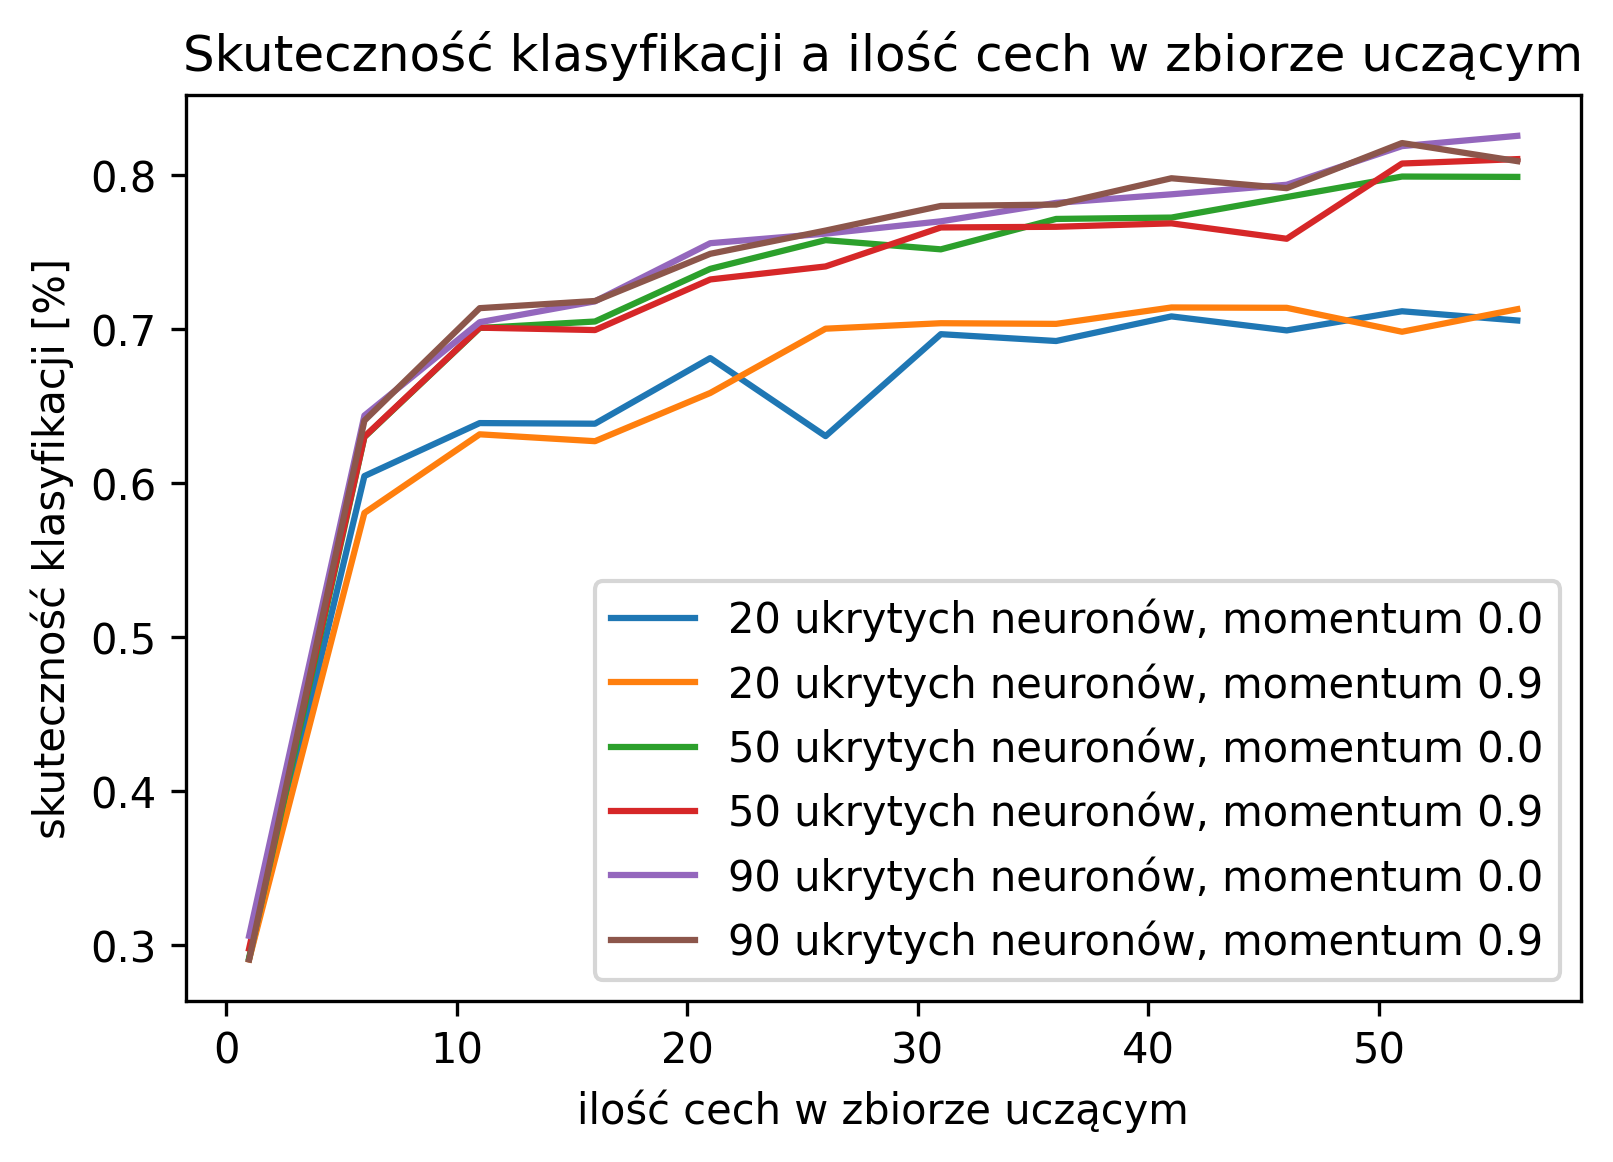

In [64]:
fig, ax = plt.subplots()

for hidden_layer_size in [20, 50, 90]:
    for momentum_value in [0.0, 0.9]:
        result = results_pandas[results_pandas['hidden_layer_size'] == hidden_layer_size]
        result = result[result['momentum'] != momentum_value]
        ax.plot(result['num_of_features'], result['mean_score'], label=f'{hidden_layer_size} ukrytych neuronów, momentum {momentum_value}')

ax.set_xlabel('ilość cech w zbiorze uczącym')
ax.set_ylabel('skuteczność klasyfikacji [%]')
plt.title('Skuteczność klasyfikacji a ilość cech w zbiorze uczącym')
plt.legend()
plt.show()

W przypadku sieci neuronowych o 20 neuronach w warstwie ukrytej, skuteczność rozpoznawania wypłaszcza się po osiągnięciu 30 cech. Większe sieci nadal zwiększają swoją skuteczność, przypuszczalnie większa ilość cech pozwoliłaby osgiągnąć jeszcze lepszą dokładność.

## Najlepsze 10 sieci pod względem średniej skuteczności

In [10]:
top_10_by_acccuracy = results_pandas.sort_values(by='mean_score', ascending=False).head(10)
top_10_by_acccuracy

,num_of_features,hidden_layer_size,momentum,mean_score,std_score
71,56,90,0.9,0.825532,0.014574
64,51,90,0.0,0.820865,0.010752
65,51,90,0.9,0.818868,0.009322
68,56,50,0.0,0.810433,0.012166
70,56,90,0.0,0.809106,0.016630
62,51,50,0.0,0.807558,0.013454
63,51,50,0.9,0.799108,0.017560
69,56,50,0.9,0.798881,0.023093
52,41,90,0.0,0.798003,0.008793
59,46,90,0.9,0.793783,0.016732


Dostrzegalna jest wyraźna przewaga sieci z dużą ilością neuronów w warstwie ukrytej.

## Najlepsze 10 sieci pod względem odchylenia standardowego

In [11]:
results_pandas.sort_values(by='std_score', ascending=True).head(10)

,num_of_features,hidden_layer_size,momentum,mean_score,std_score
3,1,50,0.9,0.291897,0.000786
0,1,20,0.0,0.290788,0.003152
52,41,90,0.0,0.798003,0.008793
65,51,90,0.9,0.818868,0.009322
11,6,90,0.9,0.643959,0.010159
14,11,50,0.0,0.700994,0.010441
35,26,90,0.9,0.762047,0.010484
64,51,90,0.0,0.820865,0.010752
53,41,90,0.9,0.787574,0.010786
58,46,90,0.0,0.791570,0.011842


Ranking otwierają dwie sieci i małej ilości neuronów w warstwie ukrytej. Ich średnia dokładność jest jednak czterokrotnie niższa, niż w przypadku pozostałych sieci w rankingu.

## Analiza statystyczna z wykorzystaniem parowych testów T-studenta

In [12]:
from scipy.stats import ttest_ind
from tabulate import tabulate

alfa = 0.05
t_statistic = np.zeros((len(clfs), len(clfs)))
p_value = np.zeros((len(clfs), len(clfs)))

for i in range(len(clfs)):
    for j in range(len(clfs)):
        t_statistic[i, j], p_value[i, j] = ttest_ind(scores[i], scores[j])
# print("t-statistic:\n", t_statistic, "\n\np-value:\n", p_value)


In [73]:
headers = [key for key in clfs.keys()]
names_column = np.array([[str(key)] for key in clfs.keys()])

t_statistic_table = np.concatenate((names_column, t_statistic), axis=1)
t_statistic_table = tabulate(t_statistic_table, headers, floatfmt=".2f")
p_value_table = np.concatenate((names_column, p_value), axis=1)
p_value_table = tabulate(p_value_table, headers, floatfmt=".2f")
# print("t-statistic:\n", t_statistic_table, "\n\np-value:\n", p_value_table)


In [74]:

advantage = np.zeros((len(clfs), len(clfs)))
advantage[t_statistic > 0] = 1
advantage_table = tabulate(np.concatenate((names_column, advantage), axis=1), headers)
# print("Advantage:\n", advantage_table)

significance = np.zeros((len(clfs), len(clfs)))
significance[p_value <= alfa] = 1
significance_table = tabulate(
    np.concatenate((names_column, significance), axis=1), headers
)
# print("Statistical significance (alpha = 0.05):\n", significance_table)


stat_better = significance * advantage
stat_better_table = tabulate(
    np.concatenate((names_column, stat_better), axis=1), headers
)
# print("Statistically significantly better:\n", stat_better_table)

In [76]:
significantly_better = [ (sum(row), network_params, np.mean(score), np.std(score)) for row, network_params, score in zip(stat_better, names_column, scores) ]

significantly_better.sort(key=lambda value: value[0], reverse=True)
top_10_best_by_significance = significantly_better[:10]

top_10_best_by_significance_pandas.columns = ['better_than', '(features, hidden_layers, momentum)', 'mean score', 'std']
top_10_best_by_significance_pandas

,better_than,"(features, hidden_layers, momentum)",mean score,std
0,69.0,"[(56, 90, 0.9)]",0.825532,0.014574
1,67.0,"[(51, 90, 0.0)]",0.820865,0.010752
2,66.0,"[(51, 90, 0.9)]",0.818868,0.009322
3,64.0,"[(56, 50, 0.0)]",0.810433,0.012166
4,62.0,"[(51, 50, 0.0)]",0.807558,0.013454
5,62.0,"[(56, 90, 0.0)]",0.809106,0.016630
6,61.0,"[(41, 90, 0.0)]",0.798003,0.008793
7,59.0,"[(51, 50, 0.9)]",0.799108,0.017560
8,56.0,"[(56, 50, 0.9)]",0.798881,0.023093
9,55.0,"[(41, 90, 0.9)]",0.787574,0.010786


# Wnioski

- Skuteczność rozpoznawania rosła w miarę dodawania nowych cech:
    - Zatrzymując się przy ponad 30 cechach sieci z 20 neuronami w warstwie ukrytej
    - Nie przestawała rosnąć przy sieciach o 50 i 90 neuronach w warstwie ukrytej
- Sieci o ukrytej warstwie mniejszej niż 50 neuronów są zdecydowanie mniej skuteczne, niż większe sieci
- Parametr pęd (`momentum`) nie miał znaczącego wpływu na wynik. W rankingach pojawiły się sieci z różnymi wartościami parametru pędu
- Mimo teoretycznie większej średniej sprawności, sieci o największym (90) rozmiarze warstwy ukrytej, nie okazały się być znacznie skuteczniejsze w testach statystycznych
